In [1]:
%cd /home/hess/projects/constrained-generation/
%load_ext autoreload
%autoreload 2

/home/hess/projects/constrained-generation


In [2]:
import time
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from IPython.display import Image, display
import matplotlib.pyplot as plt
import polars as pol
from tqdm import tqdm
import numpy as np
import xarray as xr
import xskillscore as xs
import pickle 
import pandas as pd
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from models.config import read_yaml
import models.xarray_utils as xu
from models.simulation import Simulation, SamplingConfig
from models.metrics import compute_crps, compute_crps_for_lead_times
from models.guidance import Guidance

In [29]:
diffusion_config_path = "/home/hess/projects/constrained-generation/configs/diffusion_cond_vorticity_nonsub_config.yaml"
diffusion_model_checkpoint_path = "/p/tmp/hess/scratch/discriminator-guidance/checkpoints/dm_aq2nib68/best.ckpt"

sim = Simulation(
    diffusion_config_path=diffusion_config_path,
    diffusion_model_checkpoint_path=diffusion_model_checkpoint_path,
    noise_shape=(1,1,256,256),
    variable_name="vorticity"
)

sim.initialize()

In [33]:
sim.inference.guidance = Guidance(measurement=torch.tensor([0.0], device="cuda"),
                                  gamma=5000.0,
                                  transforms=sim.transforms,
                                  loss_type="mse")

In [34]:
sampling_config = SamplingConfig(
    use_conditioning = True,
    num_rollout_steps = 5,
    num_diffusion_steps = 200,
    show_progress = True,
    show_rollout_progress = True,
    to_physical = True
)
    
results = sim.run(sampling_config)

Sample count:   0%|          | 0/5 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

In [25]:
sim = Simulation(
    diffusion_config_path=diffusion_config_path,
    diffusion_model_checkpoint_path=diffusion_model_checkpoint_path,
    noise_shape=(1,1,256,256),
    variable_name="vorticity"
)

sim.initialize()


sim.inference.guidance = Guidance(measurement=torch.tensor([0.0], device="cuda"),
                                  gamma=0.0,
                                  transforms=sim.transforms,
                                  loss_type="mse")

In [26]:
sampling_config = SamplingConfig(
    use_conditioning = True,
    num_rollout_steps = 5,
    num_diffusion_steps = 200,
    show_progress = True,
    show_rollout_progress = True,
    to_physical = True
)
    
results_no_constraint = sim.run(sampling_config)

Sample count:   0%|          | 0/5 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

Generating.. :   0%|          | 0/200 [00:00<?, ?it/s]

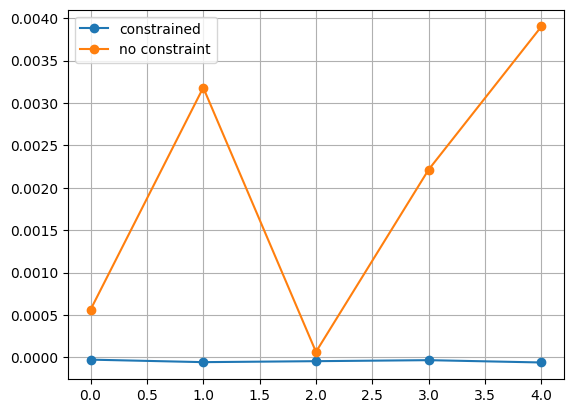

In [36]:
plt.plot(results.mean(dim=("latitude", "longitude")), marker="o", label="constrained")
plt.plot(results_no_constraint.mean(dim=("latitude", "longitude")), marker="o", label="no constraint")
plt.legend()
plt.grid()

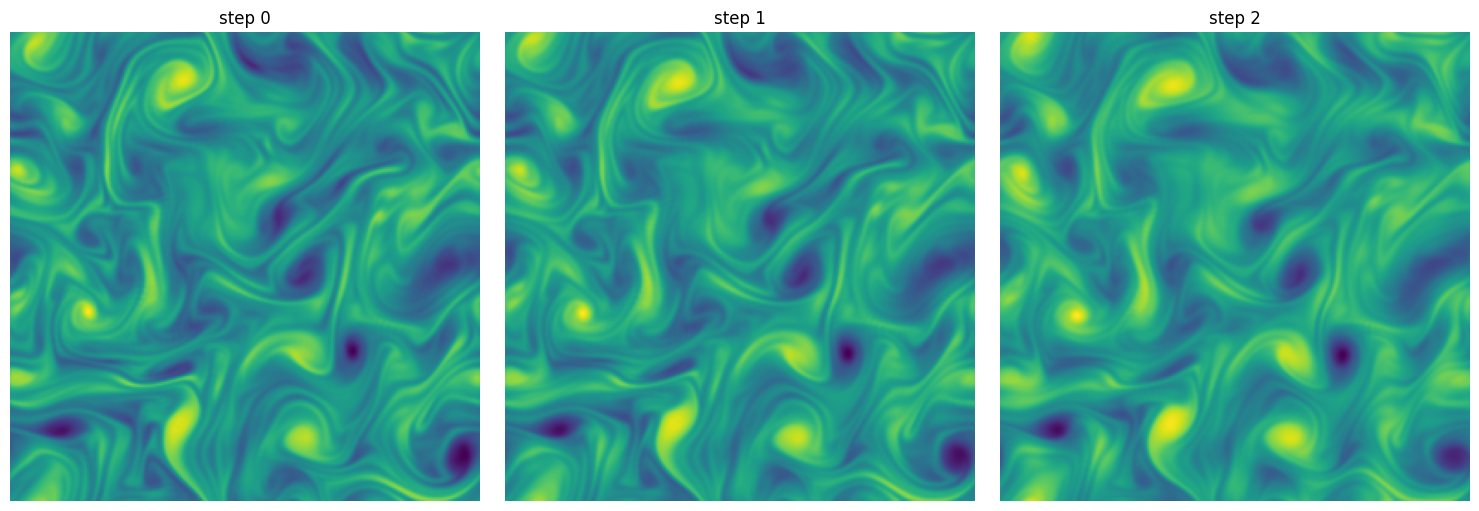

In [8]:
plt.figure(figsize=(15,5))

num_rollout_steps = sampling_config.num_rollout_steps
for i in range(num_rollout_steps):
    plt.subplot(1, num_rollout_steps, i+1)
    plt.title(f"step {i+1}")
    plt.imshow(results[i])
    plt.axis('off')
        
plt.tight_layout()
plt.show()